In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import healpy as hp
from scipy.spatial import ConvexHull
import meshio
import scipy
from pygsp.graphs import Graph
import healpy as hp
from pyevtk.hl import unstructuredGridToVTK
from pyevtk.vtk import VtkTriangle, VtkQuad
import pyshtools
import time



class MyGraph(Graph):
    
    def __init__(self, W, coords):
        super(MyGraph, self).__init__(W=W, coords=coords)
        

    
    def _init_vtk(self):
        from pyevtk.vtk import VtkTriangle, VtkQuad
        tri = ConvexHull(self.coords)
        self.simplices = tri.simplices
        self.conn = self.simplices.flatten()
        self.offset = np.arange(3,len(self.conn)+1, 3)
        self.ctype = np.ones(len(self.offset))*VtkTriangle.tid


    def save_signal(self, title='unstructured', pointData=None):
        from pyevtk.hl import unstructuredGridToVTK
        if pointData is not None:
            unstructuredGridToVTK(
                title,
                self.x,
                self.y,
                self.z,
                connectivity=self.conn,
                offsets=self.offset,
                cell_types=self.ctype,
                pointData={'Temp': pointData})
        else:
            unstructuredGridToVTK(
                title,
                self.x,
                self.y,
                self.z,
                connectivity=self.conn,
                offsets=self.offset,
                cell_types=self.ctype,
                pointData={'Temp': self.x})
        
    def save_mesh(self, file="mesh.xml"):
        self._init_vtk()
        cells = {"triangle": self.simplices}
        meshio.write_points_cells(
            file,
            self.coords,
            cells)
        
class FullEquiangular(MyGraph):

    sigmas = {1:1,
              2:0.3,
              4: 0.175, 
              8: 0.0525,
              16: 0.015,
              32: 0.004}
    
    def make_coords(self, bw):
        alpha = np.arange(2 * bw) * np.pi / bw
        beta = np.arange(2 * bw) * np.pi / (2. * bw)
        theta, phi = np.meshgrid(*(beta, alpha),indexing='ij')
        ct = np.cos(theta).flatten()
        st = np.sin(theta).flatten()
        cp = np.cos(phi).flatten()
        sp = np.sin(phi).flatten()
        x = st * cp
        y = st * sp
        z = ct
        coords = np.vstack([x, y, z]).T
        coords = np.asarray(coords, dtype=np.float32)
        coords = coords[2*bw-1:]
        self.x = coords[:,0]
        self.y = coords[:,1]
        self.z = coords[:,2]
        return coords

    
    def __init__(self, bw=8):
        self.bw = bw
        self.npix = 2*bw*(2*bw-1)+1
        coords = self.make_coords(bw)
        distances_squared = scipy.spatial.distance.cdist(coords, coords)**2
        try:
            sigma = self.sigmas[bw]
        except KeyError:
            sigma = 0.1
        W = np.exp(-distances_squared/sigma)
        W = W-np.diag(np.diag(W))
        super(FullEquiangular, self).__init__(W=W, coords=coords)
        self._init_vtk()

In [2]:
def to_signal(array):
    bw = array.shape[0]//2
    return array.flatten()[2*bw-1:]


def to_array(f):
    N = f.size
    bw = int((2+np.sqrt(4+16*N))//8)
    """From a 1-d vector to a 2D grid necessary to initiate a pyshtools.SHGrid object"""
    height, width = 2*bw, 2*bw
    array = np.zeros((height, width))  # shape=(longitude, latitude)
    f = np.append([f[0]]*(2*bw-1), f)  # correct! the first line is the North pole repeated 2bw times
    
    # now we need to undo the meshgrid
    assert f.size == array.size, print(f.size,array.size)
    for n, fx in enumerate(f):
        j = n%width
        i = n//width
        array[i, j] = fx
    return array


def _equivariance_error(clm, max_iter, _filter, plot, save):
    """Calculates the equivariance error on one signal  only
    as average of max_iter random rotations"""
    
    grid = clm.expand()
    if plot:
        grid.plot()
        if save:
            plt.savefig("original")
    angles = np.random.uniform(low=0, high=360, size=(max_iter, 3))
    
    initial_norm = np.linalg.norm(grid.data)
    norm = np.zeros(max_iter)
    t = np.zeros(2*max_iter)
    for i, [alpha, beta, gamma] in enumerate(angles):
        clm_rotated = clm.rotate(alpha, beta, gamma, degrees=True)
        grid_rotated = clm_rotated.expand()

        F_grid, c = _filter(grid)
        t[2*i] = c
        F_clm = F_grid.expand()
        RF_clm = F_clm.rotate(alpha, beta, gamma, degrees=True)
        RF_grid = RF_clm.expand()
        
        FR_grid, c = _filter(grid_rotated)
        t[2*i+1] = c
        
        if plot:
            FR_grid.plot()
            if save:
                plt.savefig("FR")
            RF_grid.plot()
            if save:
                plt.savefig("RF")
        norm[i] = np.linalg.norm(RF_grid.data-FR_grid.data)
        
        
    return np.mean(norm)/initial_norm, np.mean(t)


def equivariance_error(max_iter, _filter, plot=False, save=False, degree=None):
    """Calculates the equivariance error on max_iter signals
    with the same power spectrum as average of N random rotations each"""
    N = 5
    np.random.seed(seed=1994)
    degrees = np.arange(lmax, dtype=float)
    
    degrees[0] = np.inf
    power = np.ones(lmax) ## to calculate the result in the thesis
    
    #power = degrees**(-3) ## just for plotting
    if degree is not None:
        assert degree < lmax
        power = np.zeros(lmax)
        power[degree] = 1
    norm = np.zeros(max_iter)
    t = np.zeros(max_iter)
    for i in range(max_iter):
        clm = pyshtools.SHCoeffs.from_random(power)
        norm[i], t[i] = _equivariance_error(clm, N, _filter, plot, save)
    return np.mean(norm), np.mean(t)

# FULL HKGL

In [3]:


bw = 16

lmax = bw
sphere = FullEquiangular(bw=bw)


HKGL = np.asarray(sphere.L.todense())


eig_values, eig_vectors = scipy.linalg.eigh(HKGL)
HKGL_normalized = HKGL/np.max(eig_values)

"""
HKGL_filter = np.eye(HKGL.shape[0])
current = np.eye(HKGL.shape[0])
den = 1
for i in range(20):
    current = current@HKGL_normalized
    den = den*(i+1)
    HKGL_filter += current/den"""

def diffuse_HKGL(x):
    start = time.perf_counter()
    res = HKGL_normalized@x
    return res, time.perf_counter()-start
    


def _filter_HKGL(grid):
    array = grid.data
    f = to_signal(array)
    
    ### here goes the filtering ###
    f, t = diffuse_HKGL(f)
    
    ### ----------------------- ###
    array = to_array(f)
    return pyshtools.SHGrid.from_array(array), t




e_HKGL, t_HKGL = equivariance_error(20, _filter_HKGL, plot=False, save=False)

# FEM

In [4]:


bw = 16

lmax = bw
npix = 2*bw*(2*bw-1)+1

L = scipy.sparse.load_npz('../03.FEM_laplacian/equiangular/normal/matrices/stiffness_matrix_{}.npz'.format(bw))
B = scipy.sparse.load_npz('../03.FEM_laplacian/equiangular/normal/matrices/mass_matrix_{}.npz'.format(bw))
reordering_mask = np.load("../03.FEM_laplacian/equiangular/normal/15_reordering_masks/reordering_mask_{}.npy".format(bw))

L = L[reordering_mask]
B = B[reordering_mask]
L = L[:, reordering_mask]
B = B[:, reordering_mask]

B_inv = scipy.sparse.linalg.inv(B)

FEM_Laplacian = B_inv@L
FEM_Laplacian = np.asarray(FEM_Laplacian.todense())

eig_values, eig_vectors = scipy.linalg.eigh(FEM_Laplacian)
FEM_Laplacian_normalized = FEM_Laplacian/np.max(eig_values)

"""
FEM_filter = np.eye(FEM_Laplacian_normalized.shape[0])
current = np.eye(FEM_Laplacian_normalized.shape[0])
den = 1
for i in range(20):
    current = current@FEM_Laplacian_normalized
    den = den*(i+1)
    FEM_filter += current/den"""

def diffuse_FEM(x):
    start = time.perf_counter()
    res = FEM_Laplacian_normalized@x
    return res, time.perf_counter()-start
    


def _filter_FEM(grid):
    array = grid.data
    f = to_signal(array)
    ### here goes the filtering ###
    f, t = diffuse_FEM(f)
    ### ----------------------- ###
    array = to_array(f)
    return pyshtools.SHGrid.from_array(array), t




e_FEM, t_FEM = equivariance_error(20, _filter_FEM, plot=False, save=False)

/Users/Mart/anaconda3/envs/pdm/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/Users/Mart/anaconda3/envs/pdm/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


# SYMMETRIC LUMPED FEM

In [5]:
bw = 16

lmax = bw
npix = 2*bw*(2*bw-1)+1

L = scipy.sparse.load_npz('../03.FEM_laplacian/equiangular/normal/matrices/stiffness_matrix_{}.npz'.format(bw))
B = scipy.sparse.load_npz('../03.FEM_laplacian/equiangular/normal/matrices/mass_matrix_{}.npz'.format(bw))
reordering_mask = np.load("../03.FEM_laplacian/equiangular/normal/15_reordering_masks/reordering_mask_{}.npy".format(bw))

L = L[reordering_mask]
B = B[reordering_mask]
L = L[:, reordering_mask]
B = B[:, reordering_mask]

B_lumped_12 = scipy.sparse.diags(1./np.sqrt(np.sum((B.toarray()), axis=1)))

FEM_Laplacian = B_lumped_12@L@B_lumped_12
max_eigval = scipy.sparse.linalg.eigsh(B_lumped_12@L@B_lumped_12, 1, return_eigenvectors=False)[0]
FEM_Laplacian_normalized = FEM_Laplacian/max_eigval

"""FEM_filter = scipy.sparse.diags(np.ones(FEM_Laplacian.shape[0]))
current = scipy.sparse.diags(np.ones(FEM_Laplacian.shape[0]))
den = 1
for i in range(20):
    current = current@FEM_Laplacian_normalized
    den = den*(i+1)
    FEM_filter += current/den"""



def diffuse_FEM(x):
    start = time.perf_counter()
    res = FEM_Laplacian_normalized@x
    return res, time.perf_counter()-start


def _filter_FEM(grid):
    array = grid.data
    f = to_signal(array)
    ### here goes the filtering ###
    f, t = diffuse_FEM(f)
    ### ----------------------- ###
    array = to_array(f)
    return pyshtools.SHGrid.from_array(array), t



e_SLFEM, t_SLFEM = equivariance_error(20, _filter_FEM, plot=False, save=False)


# LUMPED FEM

In [6]:
bw = 16

lmax = bw
npix = 2*bw*(2*bw-1)+1

L = scipy.sparse.load_npz('../03.FEM_laplacian/equiangular/normal/matrices/stiffness_matrix_{}.npz'.format(bw))
B = scipy.sparse.load_npz('../03.FEM_laplacian/equiangular/normal/matrices/mass_matrix_{}.npz'.format(bw))
reordering_mask = np.load("../03.FEM_laplacian/equiangular/normal/15_reordering_masks/reordering_mask_{}.npy".format(bw))

L = L[reordering_mask]
B = B[reordering_mask]
L = L[:, reordering_mask]
B = B[:, reordering_mask]

B_lumped_inv = scipy.sparse.diags(1./np.sum((B.toarray()), axis=1))

FEM_Laplacian = B_lumped_inv@L
max_eigval = scipy.sparse.linalg.eigs(FEM_Laplacian, 1, return_eigenvectors=False)[0]
FEM_Laplacian_normalized = FEM_Laplacian/max_eigval

"""FEM_filter = scipy.sparse.diags(np.ones(FEM_Laplacian.shape[0]))
current = scipy.sparse.diags(np.ones(FEM_Laplacian.shape[0]))
den = 1
for i in range(20):
    current = current@FEM_Laplacian_normalized
    den = den*(i+1)
    FEM_filter += current/den"""



def diffuse_FEM(x):
    start = time.perf_counter()
    res = FEM_Laplacian_normalized@x
    return res, time.perf_counter()-start


def _filter_FEM(grid):
    array = grid.data
    f = to_signal(array)
    ### here goes the filtering ###
    f, t = diffuse_FEM(f)
    ### ----------------------- ###
    array = to_array(f)
    return pyshtools.SHGrid.from_array(array), t



e_LFEM, t_LFEM = equivariance_error(20, _filter_FEM, plot=False, save=False)


/Users/Mart/anaconda3/envs/pdm/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part


# KHASANOVA-FROSSARD

In [7]:
from scipy import sparse

class SphereEquiangularFrossard(Graph):
    def __init__(self, bw=64, sptype='DH', pole='all', neighbors=4, weights=None, dist=None, 
                 affine=0., **kwargs):
        """Sphere with an equiangular sampling
         Parameters
        ----------
        bw : int
            bandwidth, size of grid  (default = 64)
        sptype: str
            sampling type, possible arguments are 'DH', 'SOFT', ... (default = 'DH')
        pole: str
            how to manage the pole of the sphere, possible arguments are 'all', 'one', 'zero' (default = 'all')
        ---------
        TODO: unique on neighbor
        TODO: CC and GL are not equiangular and must be implement in other ways
        """
        self.bw = bw
        self.sptype = sptype
        self.pole = pole
        if pole not in ['all', 'one', 'zero']:
            raise ValueError('Unknown pole value:' + pole) 
        if sptype not in ['DH', 'SOFT']:
            raise ValueError('Unknown sampling type:' + sptype) 
        if sptype is not 'DH' and pole is not 'zero':
            print('pole can be only zero with sampling type ' + sptype)
            pole = 'zero'
        
        ## sampling and coordinates calculation
        if sptype is 'DH':
            beta = np.arange(2 * bw) * np.pi / (2. * bw)  # Driscoll-Heally
            alpha = np.arange(2 * bw) * np.pi / bw
            if pole is 'zero':
                beta = np.arange(2 * bw + 1) * np.pi / (2. * bw + 1)
        elif sptype is 'SOFT':  # SO(3) Fourier Transform optimal
            beta = np.pi * (2 * np.arange(2 * bw) + 1) / (4. * bw)
            alpha = np.arange(2 * bw) * np.pi / bw
        elif sptype == 'CC':  # Clenshaw-Curtis
            beta = np.linspace(0, np.pi, 2 * bw + 1)
            alpha = np.linspace(0, 2 * np.pi, 2 * bw + 2, endpoint=False)
        elif sptype == 'GL':  # Gauss-legendre
            from numpy.polynomial.legendre import leggauss
            x, _ = leggauss(bw + 1)  # TODO: leggauss docs state that this may not be only stable for orders > 100
            beta = np.arccos(x)
            alpha = np.arange(2 * bw + 2) * np.pi / (bw + 1)
        if pole is not 'all' and sptype is 'DH':
            beta = beta[1:]
        theta, phi = np.meshgrid(*(beta, alpha),indexing='ij')
        ct = np.cos(theta).flatten()
        st = np.sin(theta).flatten()
        cp = np.cos(phi).flatten()
        sp = np.sin(phi).flatten()
        x = st * cp
        y = st * sp
        z = ct
        coords = np.vstack([x, y, z]).T
        if pole is 'one':
            coords = np.vstack([[0., 0., 1.],coords])
        coords = np.asarray(coords, dtype=np.float32)
        
        ## neighbors and weight matrix calculation
        def south(x, bw):
            if x >= (2*bw)*(2*bw-1):
                return north((x+bw)%(2*bw)+(2*bw)*(2*bw),bw)
            elif self.pole is 'zero' and x >= (2*bw)*(2*bw-1):
                return north((x+bw)%(2*bw)+(2*bw)*(2*bw-1),bw)
            else:
                return x + 2*bw

        def north(x, bw):
            if x < 2*bw:
                return (x+bw)%(2*bw)
            else:
                return x - 2*bw

        def west(x, bw):
            if x%(2*bw)==0:
                x += 2*bw
            return x -1

        def east(x, bw):
            if x%(2*bw)==2*bw-1:
                x -= 2*bw
            return x + 1

        npix = len(coords)
        col_index=[]
        for ind in range(len(coords)):
            # first line is the same point, so is connected to all points of second line
            if pole is 'all' and sptype and ind < 2* bw:
                if ind == 0:
                    neighbor = np.arange(2*bw)+2*bw # np.arange(1,4*bw)
                else:
                    neighbor = np.arange(2*bw)+2*bw # [0]
            elif pole is 'all' and ind < 4*bw:
                if neighbors==8:
                    neighbor = [south(west(ind,bw),bw), west(ind,bw), east(ind,bw), south(east(ind,bw),bw), south(ind,bw)]
                elif neighbors==4:
                    neighbor = [west(ind,bw), east(ind,bw), south(ind,bw)]
                else:
                    neighbor = []
                neighbor += list(range(2*bw)) # [0]
            elif pole is 'one' and ind == 0:
                neighbor = np.arange(1, 2*bw+1)
            elif pole is 'one' and ind < 2*bw+1:
                ind += 2*bw - 1
                if neighbors==8:
                    neighbor = [south(west(ind,bw),bw), west(ind,bw), east(ind,bw), south(east(ind,bw),bw), south(ind,bw)]
                elif neighbors==4:
                    neighbor = [west(ind,bw), east(ind,bw), south(ind,bw)]
                else:
                    neighbor = []
                neighbor += [0]
            else:
                if pole is 'one':
                    ind += 2*bw - 1
                if neighbors==8:
                    neighbor = [south(west(ind,bw),bw), west(ind,bw), north(west(ind,bw), bw), north(ind,bw), 
                                north(east(ind,bw),bw), east(ind,bw), south(east(ind,bw),bw), south(ind,bw)]
                elif neighbors==4:
                    neighbor = [west(ind,bw), north(ind,bw), east(ind,bw), south(ind,bw)]
                else:
                    neighbor = []
            neighbor = np.asarray(neighbor)
            if pole is 'one' and ind != 0:
                neighbor -= 2*bw - 1
                neighbor[neighbor<0] = 0
            #neighbors.append(neighbor)
            col_index += list(neighbor)
        # neighbors = np.asarray(neighbors)
        col_index = np.asarray(col_index)

        #col_index = neighbors.reshape((-1))
        if pole is 'all':
            row_index = np.hstack([np.repeat(np.arange(0,2*bw), 2*bw), np.repeat(np.arange(2*bw,4*bw), neighbors//2+1+2*bw),#2*bw+5), 
                                  np.repeat(np.arange(4*bw, npix), neighbors)])
        elif pole is 'one':
            row_index = np.hstack([np.repeat(0, 2*bw), np.repeat(np.arange(1, 2*bw+1), neighbors//2+2),
                                  np.repeat(np.arange(2*bw+1, npix), neighbors)])
        elif pole is 'zero':
            row_index = np.repeat(np.arange(npix), neighbors)

        distances = np.sum((coords[row_index] - coords[col_index])**2, axis=1)
        # slower: np.linalg.norm(coords[row_index] - coords[col_index], axis=1)**2
        if dist=='geodesic':
            distances = np.zeros(len(row_index))
            for i, (pos1, pos2) in enumerate(zip(coords[row_index], coords[col_index])):
                d1, d2 = hp.rotator.vec2dir(pos1.T, lonlat=False).T, hp.rotator.vec2dir(pos2.T, lonlat=False).T
                distances[i] = hp.rotator.angdist(d1, d2, lonlat=False)
        
        weights = 1/distances
        
        plt.hist(distances, 100)
        
        if weights == 'one':
            weights = distances/distances


        # Similarity proposed by Renata & Pascal, ICCV 2017.
        # weights = 1 / distances

        # Build the sparse matrix.
        W = sparse.csr_matrix(
            (weights, (row_index, col_index)), shape=(npix, npix), dtype=np.float32)
        
        plotting = {"limits": np.array([-1, 1, -1, 1, -1, 1])}
        super(SphereEquiangularFrossard, self).__init__(W=W, coords=coords,
                                     plotting=plotting, **kwargs)

/Users/Mart/anaconda3/envs/pdm/lib/python3.7/site-packages/ipykernel_launcher.py:156: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


<class 'scipy.sparse.csr.csr_matrix'>


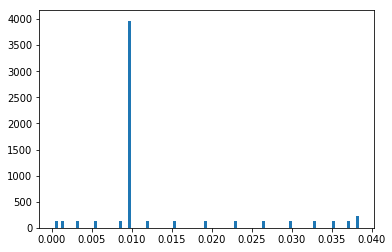

In [8]:

lmax = bw

sphere = SphereEquiangularFrossard(bw=bw)
KF = sphere.L
max_eigval = scipy.sparse.linalg.eigsh(KF, 1, return_eigenvectors=False)[0]
KF_normalized = KF/max_eigval


print(type(KF_normalized))
def diffuse_KF(x):
    start = time.perf_counter()
    res = KF_normalized@x
    return res, time.perf_counter()-start


def _filter_KF(grid):
    array = grid.data
    f = array.flatten()
    ### here goes the filtering ###
    f, t = diffuse_KF(f)
    ### ----------------------- ###
    array = np.resize(f, array.shape)
    return pyshtools.SHGrid.from_array(array), t


e_KF, t_KF = equivariance_error(20, _filter_KF, plot=False, save=False)


# SPARSE HKGL

In [9]:
import pygsp as pg

N = 15

bw = 16

lmax = bw
sphere = FullEquiangular(bw=bw)

e = np.zeros(N-1)
t = np.zeros(N-1)


    
k = 0.01


W = sphere.W.copy()
W[W < k] = 0
sparse_graph = pg.graphs.Graph(W)


HKGL = sparse_graph.L
max_eig_value = scipy.sparse.linalg.eigsh(HKGL, 1, return_eigenvectors=False)[0]
HKGL_normalized = HKGL/max_eig_value

def diffuse_HKGL(x):
    start = time.perf_counter()
    res = HKGL_normalized@x
    return res, time.perf_counter()-start



def _filter_HKGL(grid):
    array = grid.data
    f = to_signal(array)
    ### here goes the filtering ###
    f, t = diffuse_HKGL(f)
    ### ----------------------- ###
    array = to_array(f)
    return pyshtools.SHGrid.from_array(array), t




e_SPARSE_HKGL, t_SPARSE_HKGL = equivariance_error(20, _filter_HKGL, plot=False, save=False)



/Users/Mart/anaconda3/envs/pdm/lib/python3.7/site-packages/scipy/sparse/compressed.py:282: SparseEfficiencyWarning: Comparing a sparse matrix with a scalar greater than zero using < is inefficient, try using >= instead.
  warn(bad_scalar_msg, SparseEfficiencyWarning)
/Users/Mart/anaconda3/envs/pdm/lib/python3.7/site-packages/ipykernel_launcher.py:19: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


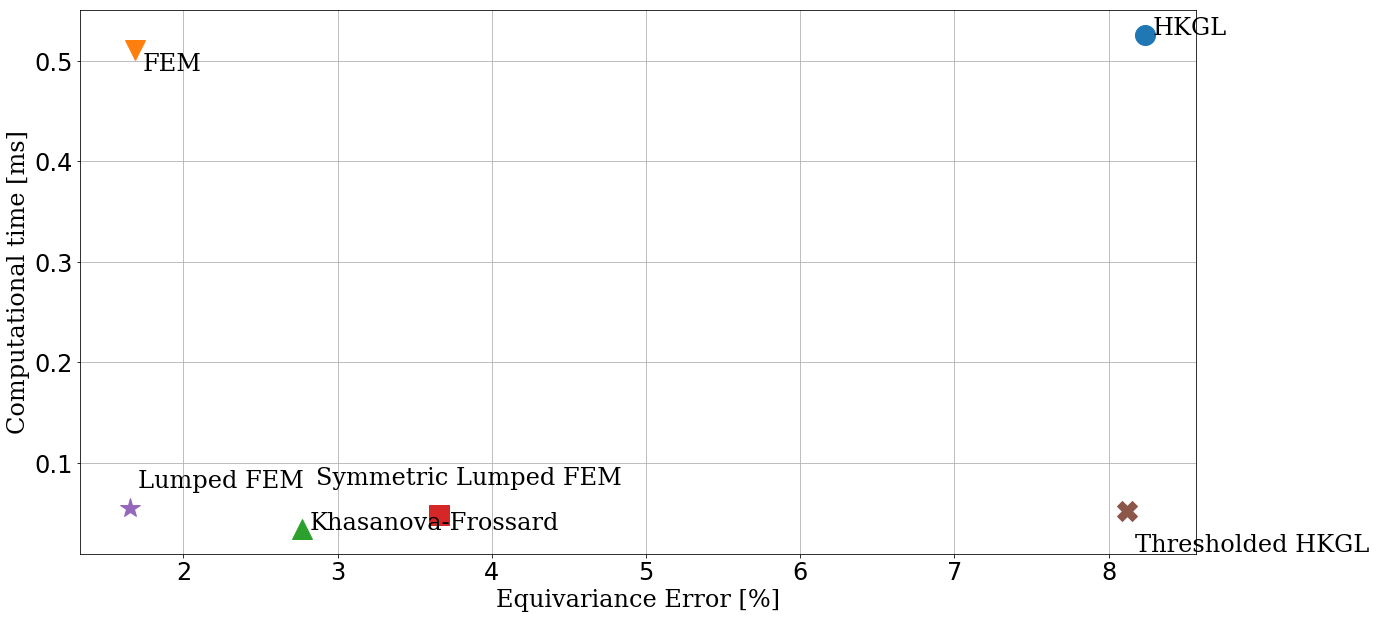

In [11]:
plt.rcParams['figure.figsize'] = (20, 10)  

font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 24,
        }


plt.plot(e_HKGL*1e2, t_HKGL*1e3, 'o', markersize=20)
plt.plot(e_FEM*1e2, t_FEM*1e3, 'v', markersize=20)
plt.plot(e_KF*1e2, t_KF*1e3, '^', markersize=20)
plt.plot(e_SLFEM*1e2, t_SLFEM*1e3, 's', markersize=20)
plt.plot(e_LFEM*1e2, t_LFEM*1e3, '*', markersize=20)
plt.plot(e_SPARSE_HKGL*1e2, t_SPARSE_HKGL*1e3, 'X', markersize=20)


plt.text(e_HKGL*1e2+0.05, t_HKGL*1e3, "HKGL", fontdict=font)
plt.text(e_FEM*1e2+0.05, t_FEM*1e3-0.02, "FEM", fontdict=font)
plt.text(e_KF*1e2+0.05, t_KF*1e3, "Khasanova-Frossard", fontdict=font)
plt.text(e_SLFEM*1e2-0.8, t_SLFEM*1e3+0.03, "Symmetric Lumped FEM", fontdict=font)
plt.text(e_LFEM*1e2+0.05, t_LFEM*1e3+0.02, "Lumped FEM", fontdict=font)
plt.text(e_SPARSE_HKGL*1e2+0.05, t_SPARSE_HKGL*1e3-0.04, 'Thresholded HKGL', fontdict=font)

plt.xlabel('Equivariance Error [%]', fontdict=font)
plt.ylabel('Computational time [ms]', fontdict=font)

plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

plt.grid()
#plt.xlim((0, 3))
#plt.ylim((0, 0.7))
# plt.savefig("tradeoff.png")

/Users/Mart/anaconda3/envs/pdm/lib/python3.7/site-packages/ipykernel_launcher.py:19: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


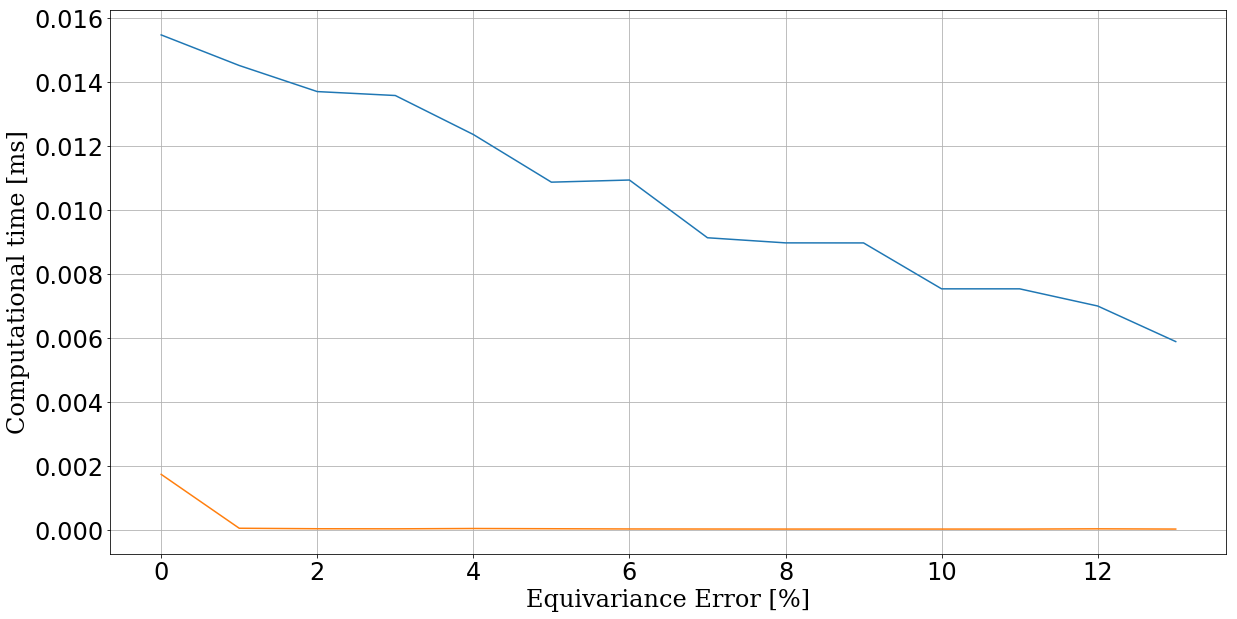

In [45]:
import pygsp as pg

N = 15

bw = 16

lmax = bw
sphere = FullEquiangular(bw=bw)

e = np.zeros(N-1)
t = np.zeros(N-1)


    
kappas = np.linspace(0,0.5, N)
for i in range(N-1):
    k = kappas[i]
    W = sphere.W.copy()
    W[W < k] = 0
    sparse_graph = pg.graphs.Graph(W)
    
    
    HKGL = sparse_graph.L
    max_eig_value = scipy.sparse.linalg.eigsh(HKGL, 1, return_eigenvectors=False)[0]
    HKGL_normalized = HKGL/max_eig_value

    def diffuse_HKGL(x):
        start = time.perf_counter()
        res = HKGL_normalized@x
        return res, time.perf_counter()-start



    def _filter_HKGL(grid):
        array = grid.data
        f = to_signal(array)
        ### here goes the filtering ###
        f, t = diffuse_HKGL(f)
        ### ----------------------- ###
        array = to_array(f)
        return pyshtools.SHGrid.from_array(array), t




    e[i], t[i] = equivariance_error(20, _filter_HKGL, plot=False, save=False)

plt.plot(e)
plt.plot(t)
plt.xlabel('Equivariance Error [%]', fontdict=font)
plt.ylabel('Computational time [ms]', fontdict=font)

plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

plt.grid()



In [59]:
print(e_HKGL*1e2, t_HKGL*1e3)
print(e_FEM*1e2, t_FEM*1e3)
print(e_KF*1e2, t_KF*1e3)
print(e_SLFEM*1e2, t_SLFEM*1e3)
print(e_LFEM*1e2, t_LFEM*1e3)
print(e_SPARSE_HKGL*1e2, t_SPARSE_HKGL*1e3)

1.5463136662394885 0.5609466999999889
0.46608988597520035 0.6195444900000612
0.644869368775153 0.04257471500004328
2.8083174928935017 0.049128089999985754
0.47044146531981956 0.0682090250002787
1.5028394620929317 0.06665259499186504
